<a href="https://colab.research.google.com/github/z-gursky/Online-Retail/blob/main/Online_Retail_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn import datasets, metrics
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
import time

In [2]:
from google.colab import files
data_to_load = files.upload()

Saving online_retail.csv to online_retail.csv


In [3]:
import io
online_retail = pd.read_csv(io.BytesIO(data_to_load['online_retail.csv']))
online_retail.shape

(1048575, 8)

This data comes from [Kaggle](https://www.kaggle.com/mashlyn/online-retail-ii-uci)

**Data Set Information:** 

This data set contains all transactions between 1/12/2009 - 9/12/2011 for a UK-based online store. This company sells unique all-occasion gift-ware and many customers of the company are wholesalers. 

**Attribute Information:**



*   **Invoice:** Invoice number, if this starts with a 'c', it indicates a cancellation. 
*   **StockCode:** *Product (item) code.*
*   **Description:** *Product (item) name.*
*   **Quantity:** *The number of each product (item) per transaction.*
*   **InvoiceDate:** *Invoice date and time.* 
*   **Customer ID:** *A 5-digit intergral number uniquely assigned to each customer.*
*   **Country:** *Country name where the customer resides.* 


**Business Goal:** 
Segment customer based on RFM so the company can target its customers more efficiently.

*   **Recency (R):** *Number of days since customers last purchase.* 
*   **Frequency (F):** *Number of transactions from the customer.*
*   **Monetary (M):** *Revenue contributed to the company.* 










# **Data Cleaning**

In [4]:
online_retail.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,12/1/2009 7:45,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,12/1/2009 7:45,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,12/1/2009 7:45,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,12/1/2009 7:45,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,12/1/2009 7:45,1.25,13085.0,United Kingdom


In [5]:
online_retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1048575 non-null  object 
 1   StockCode    1048575 non-null  object 
 2   Description  1044203 non-null  object 
 3   Quantity     1048575 non-null  int64  
 4   InvoiceDate  1048575 non-null  object 
 5   Price        1048575 non-null  float64
 6   Customer ID  811893 non-null   float64
 7   Country      1048575 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 64.0+ MB


In [6]:
# Which data is missing and how much?
def missing_data(df):
  df = df.isnull().sum()*100/df.isnull().count()
  print(df)
missing_data(online_retail)

Invoice         0.000000
StockCode       0.000000
Description     0.416947
Quantity        0.000000
InvoiceDate     0.000000
Price           0.000000
Customer ID    22.571776
Country         0.000000
dtype: float64


In [7]:
def drop_negative_values(df):
  df = df[~(df['Quantity'] < 0)] #Returned items that appear as negative
  return df
online_retail = drop_negative_values(online_retail)
missing_data(online_retail)

Invoice         0.000000
StockCode       0.000000
Description     0.164152
Quantity        0.000000
InvoiceDate     0.000000
Price           0.000000
Customer ID    22.663319
Country         0.000000
dtype: float64


In [8]:
def cleaned_data(df):
  df = df.dropna()
  return df
online_retail = cleaned_data(online_retail)
missing_data(online_retail)

Invoice        0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
Price          0.0
Customer ID    0.0
Country        0.0
dtype: float64


I have enough data to work with, will drop missing data entirely.

In [9]:
def transform_column_data(df):
  df["Amount"] = df["Quantity"] * df['Price']
  df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"],format='%m/%d/%Y %H:%M')
  return df
online_retail = transform_column_data(online_retail)

Create a new dataframe with 3 groups:

1) Average revenue contributed by customer
2) Total number of transactions
3) Last transaction made

In [10]:
# create new dataframe and add all purchases together
revenue = online_retail.groupby("Customer ID")['Amount'].sum()
revenue = revenue.reset_index()

# Count unique purchases by Invoice (same invoice #'s represent same day purchases)
transactions = online_retail.groupby("Customer ID")['Invoice'].nunique()
transactions = transactions.reset_index()

#create one dataframe
retail = pd.merge(revenue, transactions, on="Customer ID", how="inner")

# create column including date last shopped
max_date = max(online_retail['InvoiceDate'])
online_retail["recency"] = max_date - online_retail["InvoiceDate"]
online_retail.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Amount,recency
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,733 days 05:30:00
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,733 days 05:30:00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,733 days 05:30:00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,733 days 05:30:00
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,733 days 05:30:00


In [11]:
# Most recent visit
recent = online_retail.groupby("Customer ID")["recency"].min()
recent = recent.reset_index()
# Transform to days only 
recent['recency'] = recent['recency'].dt.days 

retail = pd.merge(retail, recent, on="Customer ID", how="inner")
retail.rename(columns={"Customer ID": "CustomerID", "Amount": "Amount_spent", "Invoice": "Shop_count", "recency": "Most_recent"}, inplace=True)

In [12]:
retail

,CustomerID,Amount_spent,Shop_count,Most_recent
0,12346.0,77556.46,12,320
1,12347.0,5408.50,7,34
2,12348.0,2019.40,5,70
3,12349.0,4428.69,4,13
4,12350.0,334.40,1,304
...,...,...,...,...
5858,18283.0,2528.65,21,4
5859,18284.0,461.68,1,426
5860,18285.0,427.00,1,655
5861,18286.0,1296.43,2,471


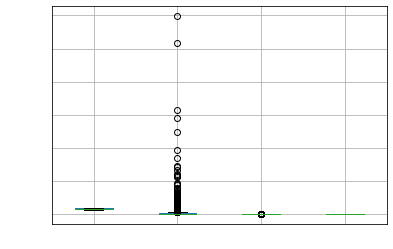

In [13]:
# correlation between variables
def outlier_visual(df):
  with plt.rc_context({'xtick.color':'white', 'ytick.color':'white', 
                      'axes.labelcolor': 'white'}):
    boxplot = df.boxplot()
outlier_visual(retail)

In [14]:
# Removing (statistical) outliers for Amount
def remove_outliers(df):
  Q1 = df.Amount_spent.quantile(0.10)
  Q3 = df.Amount_spent.quantile(0.90)
  IQR = Q3 - Q1
  df = df[(df.Amount_spent >= Q1 - 1.5*IQR) & (df.Amount_spent <= Q3 + 1.5*IQR)]

  # Removing (statistical) outliers for Recency
  Q1 = df.Most_recent.quantile(0.10)
  Q3 = df.Most_recent.quantile(0.90)
  IQR = Q3 - Q1
  df = df[(df.Most_recent >= Q1 - 1.5*IQR) & (df.Most_recent <= Q3 + 1.5*IQR)]

  # Removing (statistical) outliers for Frequency
  Q1 = df.Shop_count.quantile(0.10)
  Q3 = df.Shop_count.quantile(0.90)
  IQR = Q3 - Q1
  df = df[(df.Shop_count >= Q1 - 1.5*IQR) & (df.Shop_count <= Q3 + 1.5*IQR)]
  return df
retail = remove_outliers(retail)

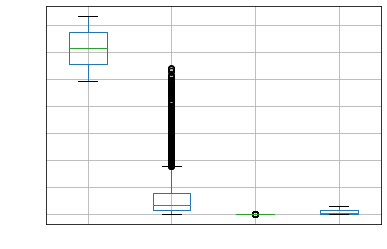

In [15]:
# correlation between variables
def outlier_visual(df):
  with plt.rc_context({'xtick.color':'white', 'ytick.color':'white', 
                      'axes.labelcolor': 'white'}):
    boxplot = df.boxplot()
outlier_visual(retail)

In [16]:
def scaled_df(data):

  X = retail[["Amount_spent", "Shop_count", "Most_recent"]]

  scaler = StandardScaler()
  X_std = scaler.fit_transform(X)
  return X_std
X_std = scaled_df(retail)

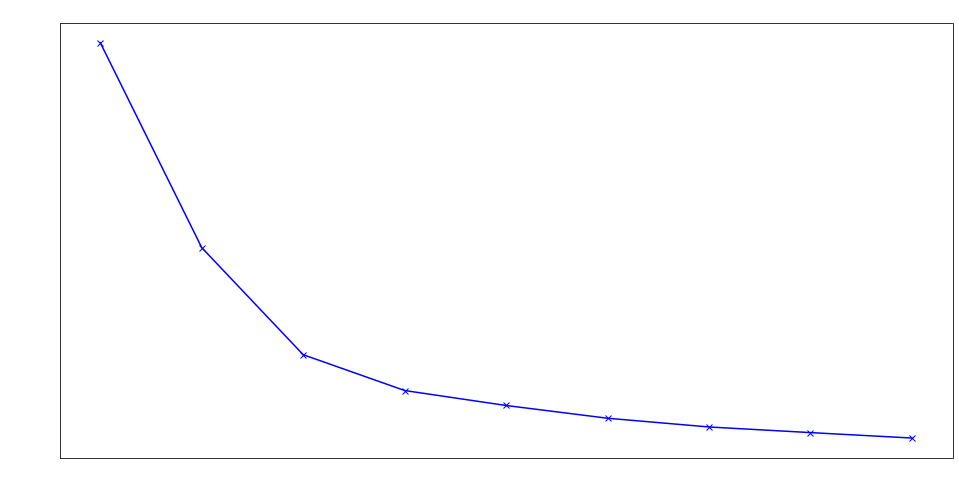

[16880.999999999993,
 9140.237173609003,
 5097.753163653622,
 3745.234456838288,
 3180.203783218961,
 2698.7274106286327,
 2368.7721780644833,
 2156.5230097229105,
 1951.178802005688]

In [17]:
def cluster_number(cluster_method):
  with plt.rc_context({'xtick.color':'white', 'ytick.color':'white', 
                      'axes.labelcolor': 'white'}):
    distortions = []
    K = range(1,10)
    for k in K:
      kmeans_cluster = cluster_method(n_clusters=k)
      kmeans_cluster.fit(X_std)
      distortions.append(kmeans_cluster.inertia_)

    plt.figure(figsize=(16,8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k', color='white')
    plt.show()
    return distortions
cluster_number(KMeans)

In [18]:
kmeans_cluster = KMeans(n_clusters=3, random_state=123)
# Fit model
kmeans_cluster.fit(X_std)
y_pred = kmeans_cluster.predict(X_std)
# make labels to index coloring
labels = kmeans_cluster.labels_
clusters = pd.concat([retail, pd.DataFrame({'Cluster':labels})], axis=1)

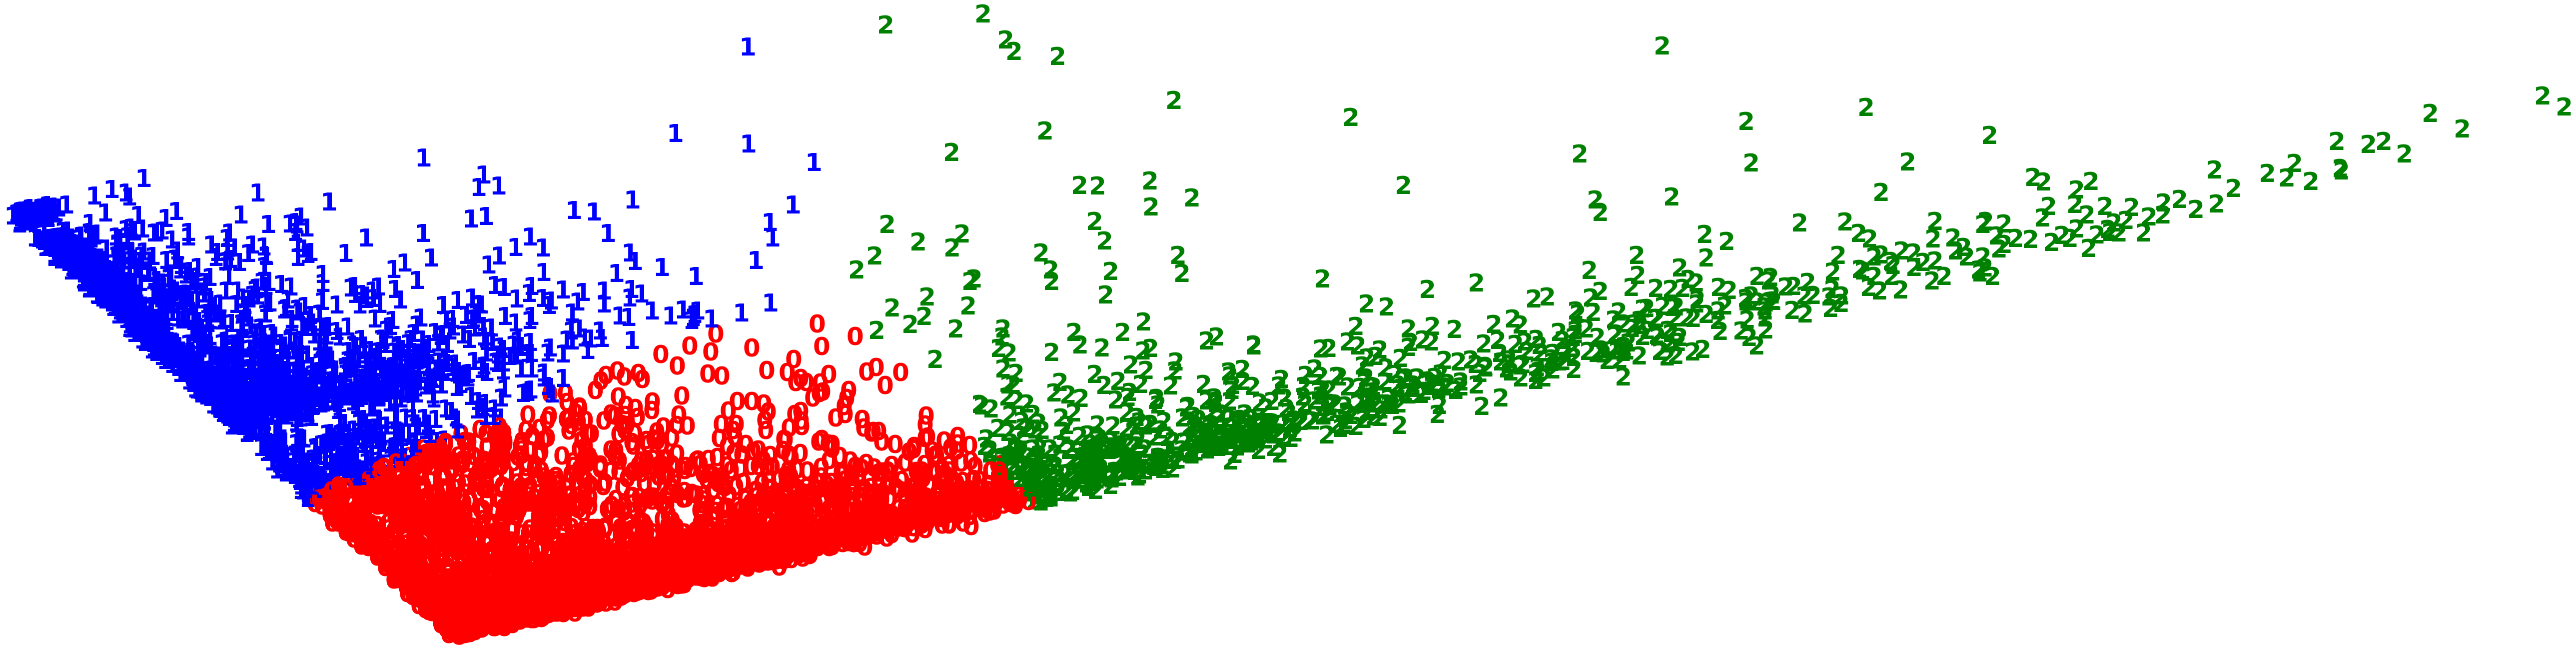

In [19]:
# Defining the mini-batch k-means
def cluster_algorithm(method):
  pca = PCA(n_components=2).fit_transform(X_std)
  cluster = method
  # Fit model
  cluster.fit(X_std)
  
  if method == "Kmeans":
    cluster = cluster.predict(X_std)
  else:
    cluster = cluster.fit_predict(X_std)
  
  plt.figure(figsize=(10,5))
  colours = ["r", "b", "g"]
  for i in range(pca.shape[0]):
      plt.text(pca[i, 0], pca[i, 1], str(cluster[i]),
              color=colours[labels[i]],
              fontdict={'weight': 'bold', 'size': 50}
          )

  plt.xticks([])
  plt.yticks([])
  plt.axis('off')
  plt.show()

kmeans_cluster = cluster_algorithm(KMeans(n_clusters=3, 
                                          random_state=123))

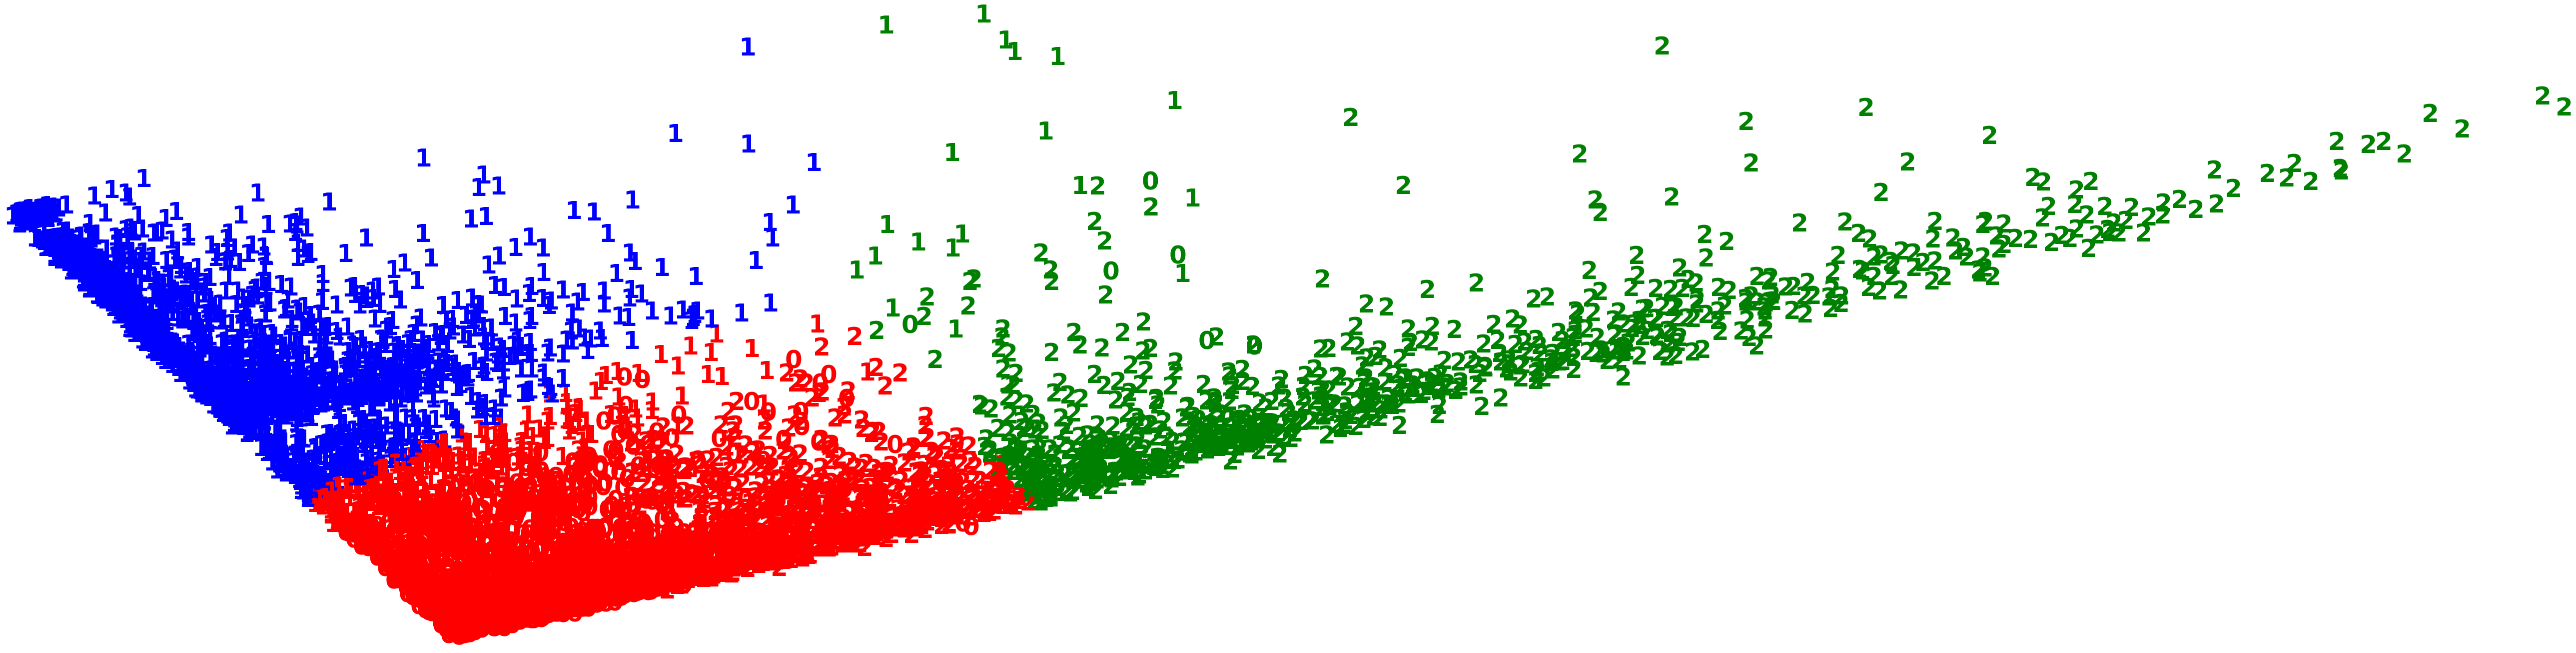

In [20]:
# Defining the agglomerative clustering
agg_cluster = cluster_algorithm(AgglomerativeClustering(linkage='complete', 
                                      affinity='cosine',
                                      n_clusters=3))

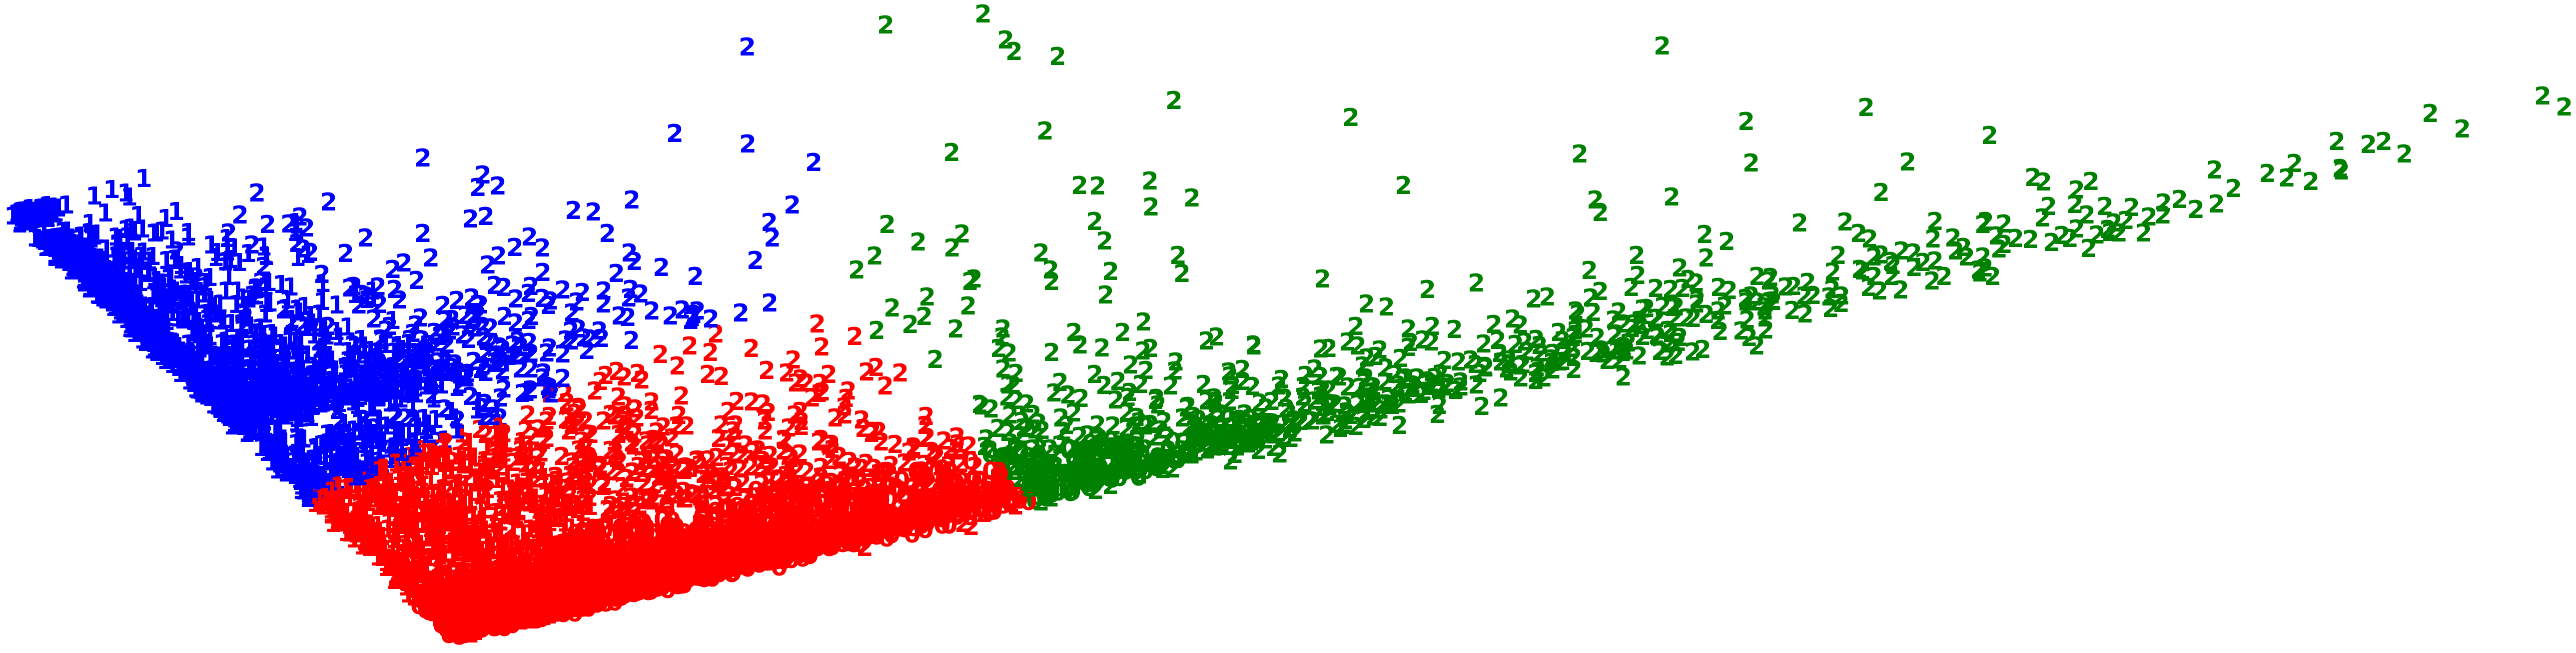

In [21]:
# Defining the GMM clustering
from sklearn.mixture import GaussianMixture
gmm_cluster = cluster_algorithm(GaussianMixture(n_components=3, random_state=123))

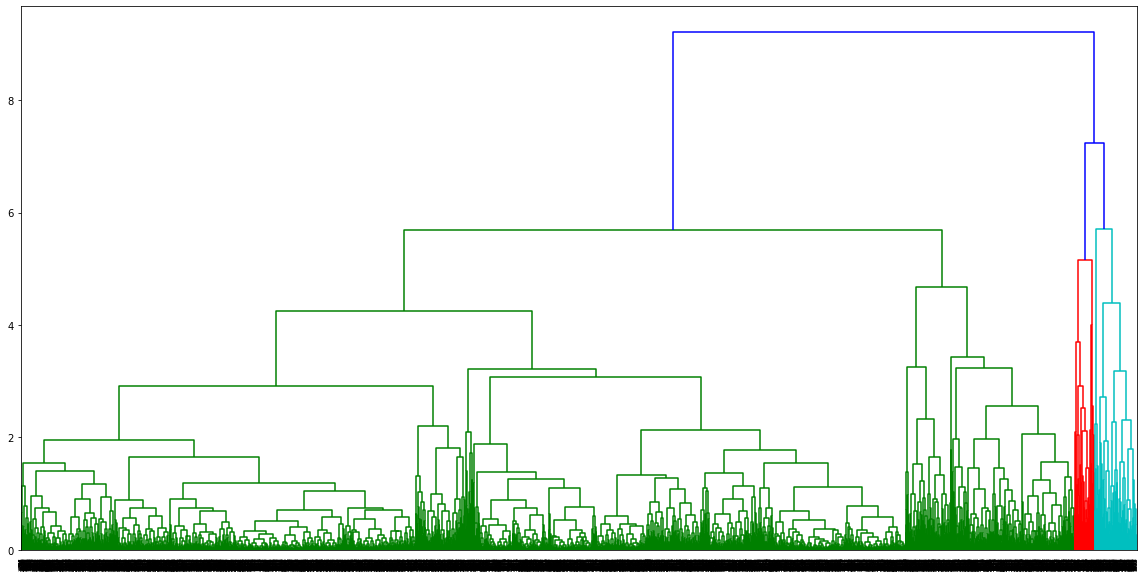

In [22]:
plt.figure(figsize=(20,10))
dendrogram(linkage(X_std, method='complete'))
plt.show()

In [23]:
def adjusted_rand_index_score(method):
  pca = PCA(n_components=2).fit_transform(X_std)
  cluster = method
  # Fit model
  cluster.fit(X_std)
  
  if method == "Kmeans":
    cluster = cluster.predict(X_std)
  else:
    cluster = cluster.fit_predict(X_std)

  return cluster
ari_kmeans = adjusted_rand_index_score(KMeans(n_clusters=3, 
                                          random_state=123))
ari_agg = adjusted_rand_index_score(AgglomerativeClustering(linkage='complete', 
                                      affinity='cosine',
                                      n_clusters=3))
ari_gmm = adjusted_rand_index_score(GaussianMixture(n_components=3, random_state=123))

In [24]:
print("Adjusted Rand Index of the Kmeans Clustering solution: {}"
      .format(metrics.adjusted_rand_score(labels, ari_kmeans)))
print("The silhoutte score of the Kmeans Clustering solution: {}"
      .format(metrics.silhouette_score(X_std, ari_kmeans, metric='euclidean')))
print("---------------------------------------------------------")
print("Adjusted Rand Index of the Agglomerative Clustering solution: {}"
      .format(metrics.adjusted_rand_score(labels, ari_agg)))
print("The silhoutte score of the Agglomerative Clustering solution: {}"
      .format(metrics.silhouette_score(X_std, ari_agg, metric='euclidean')))
print("----------------------------------------------------------")
print("Adjusted Rand Index of the Gaussian Mixture clustering solution: {}"
      .format(metrics.adjusted_rand_score(labels, ari_gmm)))
print("The silhoutte score of the Gaussian Mixture clustering solution: {}"
      .format(metrics.silhouette_score(X_std, ari_gmm, metric='euclidean')))

Adjusted Rand Index of the Kmeans Clustering solution: 1.0
The silhoutte score of the Kmeans Clustering solution: 0.4850851954396983
---------------------------------------------------------
Adjusted Rand Index of the Agglomerative Clustering solution: 0.5335781947648948
The silhoutte score of the Agglomerative Clustering solution: 0.38140100799394344
----------------------------------------------------------
Adjusted Rand Index of the Gaussian Mixture clustering solution: 0.3570459406371299
The silhoutte score of the Gaussian Mixture clustering solution: 0.2828639467917761


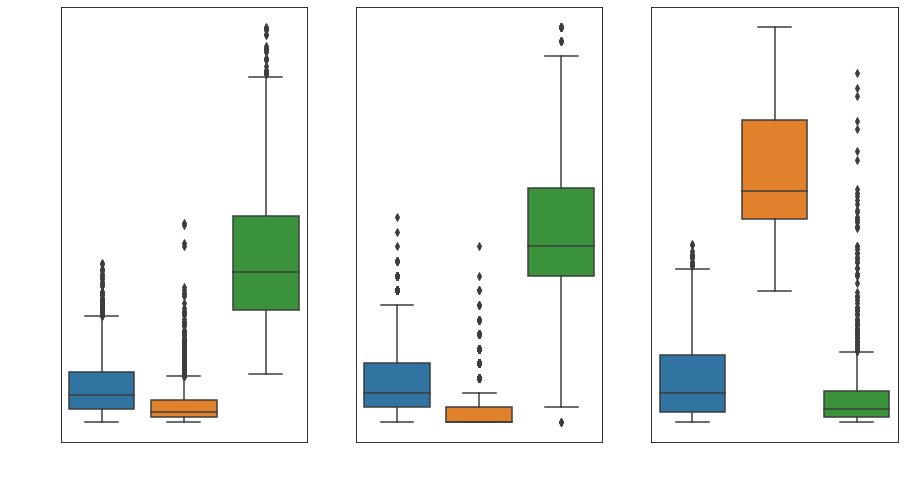

In [25]:
retail["Cluster"] = labels
with plt.rc_context({'xtick.color':'white', 'ytick.color':'white', 
                     'axes.labelcolor': 'white'}):
  plt.figure(figsize=(15,8))
  plt.subplot(1,3,1)
  sns.boxplot(x='Cluster', y='Amount_spent', data=retail)

  plt.subplot(1,3,2)
  sns.boxplot(x='Cluster', y='Shop_count', data=retail)

  plt.subplot(1,3,3)
  sns.boxplot(x='Cluster', y='Most_recent', data=retail)

Interpertations of Clusters:



*   **Cluster 0:**


> Amount spent is Low-Medium without frequently shopping at this store. They have returned within the past few months. 


*   **Cluster 1:**


> This cluster spent the least amount of money, shopped the most infrequent and have not been back 1-2 years. 



*   **Cluster 2:**


> Highest amount spent with returning to the store most frequently and most recent. 

We do not have exsisting labels so I will use Silhoutte score.


*   Values of silhoutte score range between -1 to 1. 


*   Scores closer to 1 indicate the data point is very similar to other points in the cluster.


*   Scores closer to -1 indicate that the data point is not similar to the data points in its cluster. 

It appears that the Kmeans Clustering Algorithm used produced the best silhoutte score. This will give us clusters of datapoints that are closer to other datapoints in the cluster than they are to datapoints in other clusters. From the visualizations above it appears cluster 1 has the least importance and cluster 2 has the most importance with cluster 0 somewhere in between from a business point of view. 



